#### Hoeffding Inequality - see bottom

## Linear Regression

In [1]:
%reset -sf

In [2]:
%matplotlib inline
import datetime
import numpy as np
import matplotlib.pyplot as plt
from numba.decorators import jit
from statsmodels.distributions.empirical_distribution import ECDF

In [3]:
vmin = -1.
vmax = 1.

@jit
def rand_points(num=1):
    return np.append(np.ones((num,1)),
                     np.random.random((num,2))*(vmax-vmin)+vmin,
                     axis=1)

@jit
def rand_line():
    return rand_points(2)

@jit
def line2coef(xyline):
    x1, y1 = xyline[0,1], xyline[0,2]
    x2, y2 = xyline[1,1], xyline[1,2]
    # y = ax + b
    a = (y2-y1) / (x2-x1)
    b = y1 - a*x1
    return a,b

@jit
def points_higher(points, xyline):
    a, b = line2coef(xyline)
    return np.sign(points[:,2] - (a*points[:,1]+b))

def plot_line(xyline, style='k', dots=False):
    def bound_point(x):
        a, b = line2coef(xyline)
        y = a*x+b
        y = min(y, vmax)
        y = max(y, vmin)
        x = (y-b) / a
        return x,y
    x1, y1 = bound_point(vmin)
    x2, y2 = bound_point(vmax)
    line_style = style[0] + '-'
    plt.plot([x1,x2], [y1,y2], line_style)
    if dots:
        dot_style = style
        if len(dot_style) == 1:
            dot_style += 'o'
        plot_points(xyline, dot_style)

def plot_points(points, styles='k'):
    if isinstance(styles, str):
        styles = np.full((points.shape[0],), styles, dtype='<U2')
    for p, s in zip(points, styles):
        if len(s) == 1:
             s += 'o'
        plt.plot([p[1]], [p[2]], s)

def points_style(farr, garr=None):
    if garr is None:
        garr = farr
    color = np.where(garr == farr, 'b', 'r')
    form = np.where(garr > 0, 'x', '+')
    return np.char.add(color, form)

In [4]:
@jit
def linreg(X, y):
    m = 2
    if m == 1:
        Pinv = np.linalg.pinv(X)
    else:
        Pinv = np.linalg.inv(X.T @ X) @ X.T
    return Pinv @ y

@jit
def err_freq(f, g):
    return np.count_nonzero(f != g) / f.size

@jit
def points_sign(p, w):
    return np.sign(np.inner(p, w))

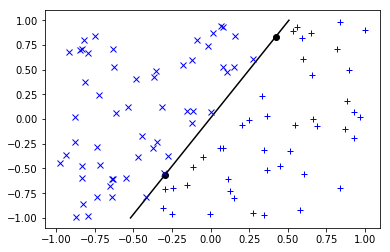

In [5]:
rline = rand_line()
points1 = rand_points(100)
target1 = points_higher(points1, rline)
plot_line(rline, dots=1)
plot_points(points1, points_style(target1))

### Calculate Ein and Eout

In [6]:
N = 10000
M = 100

L = [None] * N
x = np.empty([N, M, 3])
f = np.empty([N, M])
w = np.empty([N, 3])
g = np.empty([N, M])
ein = np.empty([N])

for i in range(N):
    L[i] = rand_line()
    x[i] = rand_points(M)
    f[i] = points_higher(x[i], L[i])
    w[i] = linreg(x[i], f[i])
    g[i] = points_sign(x[i], w[i])
    ein[i] = err_freq(f[i], g[i])

print("avg Ein: %f" % ein.mean())

avg Ein: 0.039172


In [7]:
M_out = 1000
x_out = rand_points(M_out)
e_out = np.empty([N])

for i in range(N):
    f_out = points_higher(x_out, L[i])
    g_out = points_sign(x_out, w[i])
    e_out[i] = err_freq(f_out, g_out)

print("avg Eout: %f" % e_out.mean())

avg Eout: 0.047658


### New-Way PLA

In [8]:
@jit
def pla(x, f, w):
    n = 0
    while 1:
        h = points_sign(x, w)
        e = f - h
        fail = np.where(e != 0)[0]
        if fail.size == 0:
            break
        i = np.random.choice(fail)
        w += e[i] * x[i]
        n += 1
    return w, n

In [9]:
n_all = []
for i in range(10000):
    L = rand_line()
    x = rand_points(10)
    f = points_higher(x, L)
    w1 = linreg(x, f)
    w2, n2 = pla(x, f, w1)
    n_all.append(n2)

print("mean n iters: %.1f" % np.mean(n_all))

mean n iters: 4.7


## Nonlinear Transformation

In [10]:
%reset -sf

In [11]:
%matplotlib inline
import datetime
import numpy as np
import matplotlib.pyplot as plt
from numba.decorators import jit
from statsmodels.distributions.empirical_distribution import ECDF

In [12]:
@jit
def linreg(X, y):
    m = 2
    if m == 1:
        Pinv = np.linalg.pinv(X)
    else:
        Pinv = np.linalg.inv(X.T @ X) @ X.T
    return Pinv @ y

@jit
def points_sign(p, w):
    return np.sign(np.inner(p, w))

@jit
def err_freq(f, g):
    return np.count_nonzero(f != g) / f.size

### Task 8: Without Transformation

In [13]:
N = 1000
M = 1000

# training set
x = np.random.random([N, M, 3]) * 2 - 1
x[...,0] = 1

# target function
f = np.sign(x[...,1]**2 + x[...,2]**2 - 0.6)

# target function with 10% random noise
y = f.copy()
for i in range(N):
    y[i, np.random.randint(M, size=int(M * 0.10))] *= -1

# carry out linear regression
ein = np.empty([N])
for i in range(N):
    wi = linreg(x[i], y[i])
    gi = points_sign(x[i], wi)
    ein[i] = err_freq(y[i], gi)

print('avg Ein: %s' % ein.mean())

avg Ein: 0.506792


### Task 9: Use Transformation

In [14]:
# Transform input
ones, x1, x2 = x[...,[0]], x[...,[1]], x[...,[2]]
z = np.concatenate([ones, x1, x2, x1*x2, x1**2, x2**2], axis=2)

# Lin.reg. for transformation
wz = np.empty([N, 6])
for i in range(N):
    wz[i] = linreg(z[i], y[i])

eout_z = [err_freq(y[i], points_sign(z[i], wz[i])) for i in range(N)]
print('avg transformed Ein: %s' % np.mean(eout_z))

avg transformed Ein: 0.118833


In [15]:
# The final function
z_ok = z[0]
w_ok = wz[0]
h_ok = points_sign(z_ok, w_ok)

print('my candidate: %s' % w_ok)

my candidate: [-1.02141928  0.02188335 -0.00879353  0.09499471  1.66741879  1.54154997]


In [16]:
# Candidates from the problem
z_cand = np.array([
    [-1., -0.05, 0.08, 0.13, 1.5, 1.5],
    [-1., -0.05, 0.08, 0.13, 1.5, 15.],
    [-1., -0.05, 0.08, 0.13, 15., 1.5],
    [-1., -1.5,  0.08, 0.13, .05, .05],
    [-1., -0.05, 0.08, 1.5,  .15, .15],
])

# Determine the best candidate
e_all = []
for i in range(z_cand.shape[0]):
    cand_i = points_sign(z_ok, z_cand[i])
    e = err_freq(cand_i, h_ok)
    e_all.append(e)
    print("candidate {} error {}".format(i, e))

print("best candidate: {}".format(z_cand[np.argmin(e_all)]))

candidate 0 error 0.038
candidate 1 error 0.348
candidate 2 error 0.347
candidate 3 error 0.351
candidate 4 error 0.424
best candidate: [-1.   -0.05  0.08  0.13  1.5   1.5 ]


### Task 10: Verify $E_{out}$

In [17]:
# training set in the range [-1,=1]
xo = np.random.random([N, M, 3]) * 2 - 1
xo[...,0] = 1

# target function
fo = np.sign(xo[...,1]**2 + xo[...,2]**2 - 0.6)

# target function with 10% random noise
yo = fo.copy()
for i in range(N):
    yo[i, np.random.randint(M, size=int(M * 0.10))] *= -1

# transformed set
ones, x1, x2 = xo[...,[0]], xo[...,[1]], xo[...,[2]]
zo = np.concatenate([ones, x1, x2, x1*x2, x1**2, x2**2], axis=2)

# verify linear regression
eo = np.empty((N,))
for i in range(N):
    goi = points_sign(zo[i], wz[i])
    eo[i] = err_freq(yo[i], goi)

print('avg Eout: %s' % eo.mean())

avg Eout: 0.121606


## Hoeffding Inequality

Run a computer simulation for flipping 1,000 virtual fair coins. Flip each coin independently 10 times. Focus on 3 coins as follows: $c_1$ is the first coin flipped, crand is a
coin chosen randomly from the 1,000, and cmin is the coin which had the minimum
frequency of heads (pick the earlier one in case of a tie). Let $\nu_1$, νrand, and νmin be
the fraction of heads obtained for the 3 respective coins out of the 10 tosses.

Run the experiment 100,000 times in order to get a full distribution of $\nu_1$, $ν_{rand}$, and
$ν_{min}$ (note that crand and cmin will change from run to run).

In [18]:
%reset -sf

In [19]:
%matplotlib inline
import datetime
import numpy as np
import matplotlib.pyplot as plt
from numba.decorators import jit
from statsmodels.distributions.empirical_distribution import ECDF

In [20]:
N = 100000
M = 1000
S = 10
c1 = np.empty(N)
crand = np.empty(N)
cmin = np.empty(N)
for k in range(N):
    heads = np.empty(M)
    for i in range(M):
        heads[i] = np.random.randint(2, size=S).mean()
    c1[k] = heads[0]
    crand[k] = heads[np.random.randint(M)]
    cmin[k] = heads.min()
    if k % 10000 == 0:
        now = datetime.datetime.now().replace(second=0,microsecond=0)
        print("{!s} {:-5} ...".format(now, k))

2017-10-22 10:09:00     0 ...
2017-10-22 10:14:00 10000 ...
2017-10-22 10:19:00 20000 ...
2017-10-22 10:24:00 30000 ...
2017-10-22 10:29:00 40000 ...
2017-10-22 10:34:00 50000 ...
2017-10-22 10:40:00 60000 ...
2017-10-22 10:45:00 70000 ...
2017-10-22 10:50:00 80000 ...
2017-10-22 10:55:00 90000 ...


In [21]:
print(c1.mean())
print(crand.mean())
print(cmin.mean())

0.500243
0.500141
0.037483


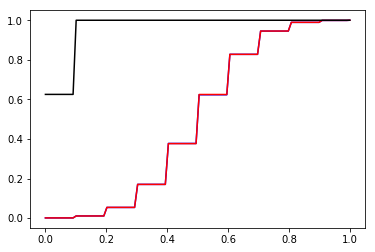

In [22]:
xs = np.linspace(0, 1, 100)
plt.plot(xs, ECDF(c1)(xs), 'b')
plt.plot(xs, ECDF(crand)(xs), 'r')
plt.plot(xs, ECDF(cmin)(xs), 'k')

### *END*